# Golf putting case study in JAX

Using TFP-JAX and Blackjax

Originally a [Stan case study](https://mc-stan.org/users/documentation/case-studies/golf.html), you can also find the port in [PyMC3](https://www.pymc.io/projects/docs/en/v3/pymc-examples/examples/case_studies/putting_workflow.html), [TFP](https://adamhaber.github.io/post/nuts/), and[Turing.jl](https://burtonjosh.github.io/blog/golf-putting-in-turing/).

The data set is from “Statistics: A Bayesian Perspective”, by Don Berry (1995), which describes the outcome of professional golfers putting from a number of distances.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import pandas as pd

Read data and reproduce some figures

In [2]:
golf_data = pd.read_csv("data/golf_data.csv")
golf_data_new = pd.read_csv("data/golf_data_new.csv")
for tbl in [golf_data, golf_data_new]:
    tbl["prob"] = tbl["successes"] / tbl["attempts"]
    tbl["stddev"] = np.sqrt(tbl["prob"] * (1 - tbl["prob"]) / tbl["attempts"])
    tbl = tbl.convert_dtypes(np.float32)


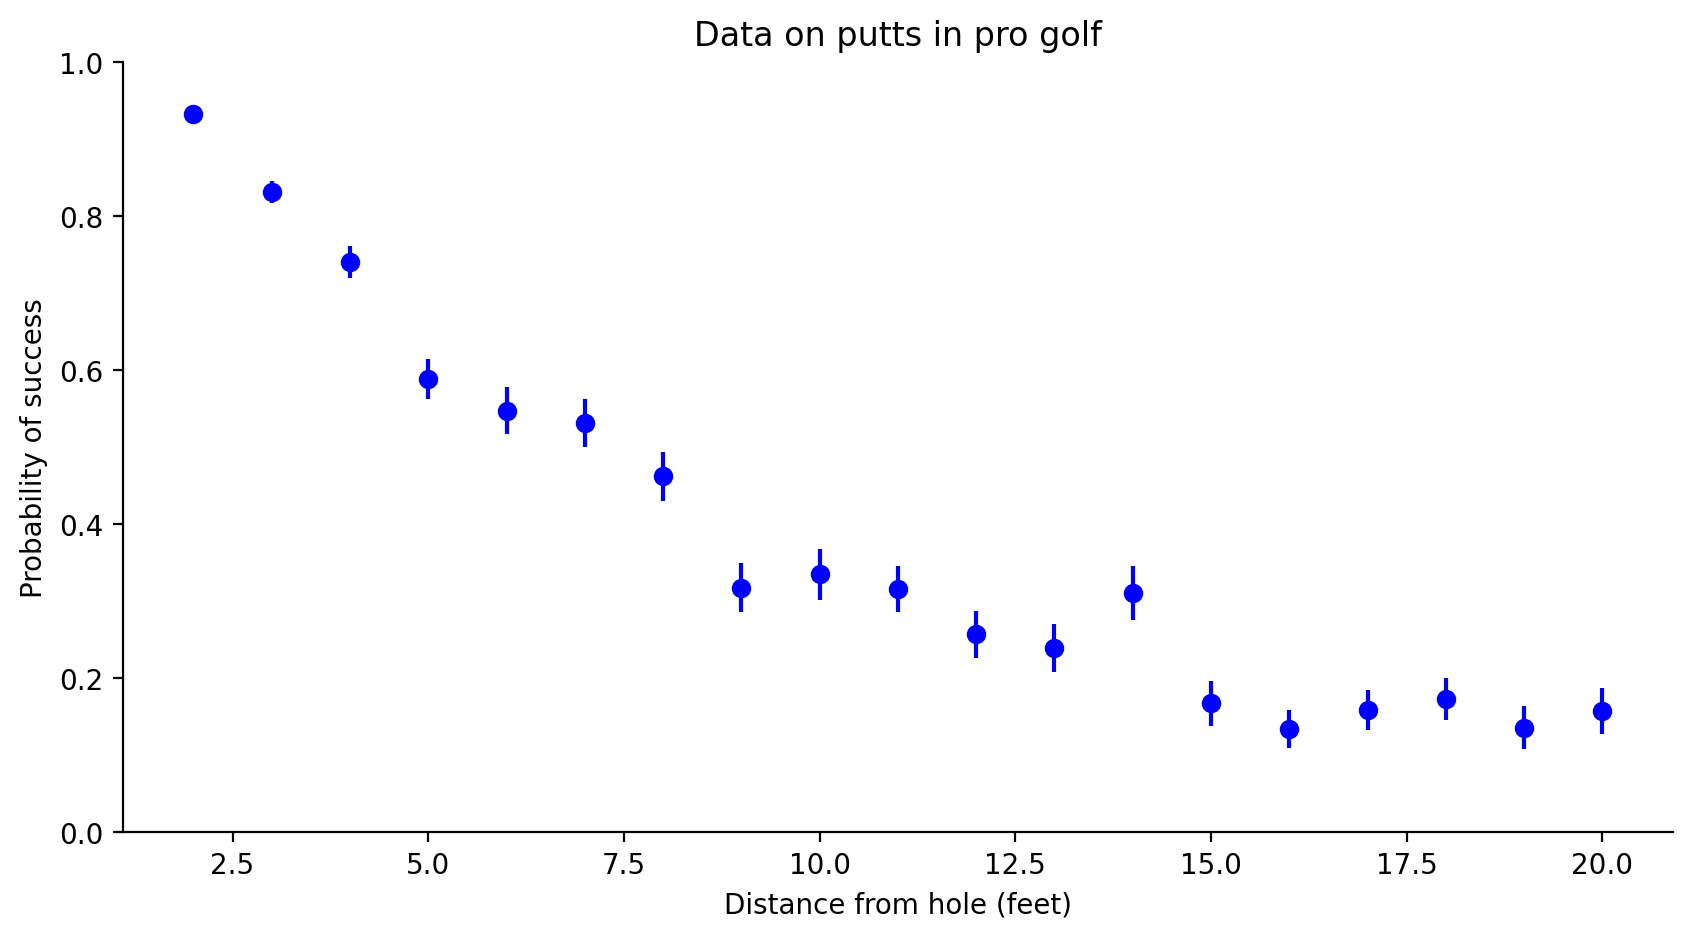

In [3]:
def plot_observed(golf_tbl, ax=None, plot_err=True):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 5))
    if plot_err:
        ax.errorbar(
            golf_tbl["distance"],
            golf_tbl["prob"],
            yerr=golf_tbl["stddev"],
            fmt="o",
            color="b",
        )
    else:
        ax.plot(golf_tbl["distance"], golf_tbl["prob"], "o", color="r")
    ax.set(
        ylim=(0, 1),
        xlabel="Distance from hole (feet)",
        ylabel="Probability of success",
        title="Data on putts in pro golf",
    )
    ax.spines[["right", "top"]].set_visible(False)
    return ax


ax = plot_observed(golf_data)


## First model (logit model) and inference

A bit of boilerplate code ahead

In [4]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions
jdc = tfp.distributions.JointDistributionCoroutineAutoBatched

from datetime import datetime

seed = int(datetime.today().strftime("%Y%m%d"))
rng = jax.random.PRNGKey(seed)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
def gen_logistic_regression(distance, attempts):
    @jdc
    def model():
        a = yield tfd.Normal(0, 10, name="a")
        b = yield tfd.Normal(0, 10, name="b")
        logit_p = a + distance * b
        yield tfd.Binomial(attempts, logits=logit_p, name="y")

    return model


distance = np.asarray(golf_data["distance"].values, dtype=np.float32)
attempts = np.asarray(golf_data["attempts"].values, dtype=np.float32)
successes = np.asarray(golf_data["successes"].values, dtype=np.float32)

golf_logistic = gen_logistic_regression(distance, attempts)


In [6]:
# Some usual ways to check shapes

# golf_logistic.sample(3, seed=rng)
# golf_logistic._sample_and_log_prob(3, seed=rng)


In [7]:
# Condition on the observed
pinned_model = golf_logistic.experimental_pin(y=successes)
# Again, shape checking
pinned_model.sample_and_log_weight(3, seed=rng)


(StructTuple(
   a=Array([ 8.716739 , -2.025279 ,  4.2883434], dtype=float32),
   b=Array([ 7.948434, -4.401197, 14.804815], dtype=float32)
 ),
 Array([-255462.06 ,  -76523.055, -447235.12 ], dtype=float32))

In [8]:
# we use 4 chains for sampling
n_chains = 4
rng, init_key = jax.random.split(rng, 2)
init_params = pinned_model.sample_unpinned(n_chains, seed=init_key)
joint_logdensity = pinned_model.unnormalized_log_prob


In [9]:
import blackjax


In [10]:
warmup = blackjax.window_adaptation(blackjax.nuts, joint_logdensity)

rng, warmup_key = jax.random.split(rng, 2)
keys = jax.random.split(warmup_key, n_chains)


@jax.vmap
def call_warmup(seed, param):
    (initial_states, tuned_params), _ = warmup.run(seed, param, 1000)
    return initial_states, tuned_params


initial_states, tuned_params = call_warmup(keys, init_params)


In [11]:
def inference_loop_multiple_chains(
    rng_key, initial_states, tuned_params, log_prob_fn, num_samples, num_chains
):
    step_fn = blackjax.nuts.kernel()

    def kernel(key, state, **params):
        return step_fn(key, state, log_prob_fn, **params)

    def one_step(states, rng_key):
        keys = jax.random.split(rng_key, num_chains)
        states, infos = jax.vmap(kernel)(keys, states, **tuned_params)
        return states, (states, infos)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_states, keys)

    return (states, infos)


n_samples = 1000
rng, sample_key = jax.random.split(rng, 2)
states, infos = inference_loop_multiple_chains(
    sample_key, initial_states, tuned_params, joint_logdensity, n_samples, n_chains
)


In [12]:
import arviz as az


def arviz_trace_from_states(states, info, burn_in=0):
    position = states.position
    if isinstance(position, jnp.DeviceArray):  # if states.position is array of samples
        position = dict(samples=position)
    else:
        try:
            position = position._asdict()
        except AttributeError:
            pass

    samples = {}
    for param in position.keys():
        ndims = len(position[param].shape)
        if ndims >= 2:
            samples[param] = jnp.swapaxes(position[param], 0, 1)[
                :, burn_in:
            ]  # swap n_samples and n_chains
            divergence = jnp.swapaxes(info.is_divergent[burn_in:], 0, 1)

        if ndims == 1:
            divergence = info.is_divergent
            samples[param] = position[param]

    trace_posterior = az.convert_to_inference_data(samples)
    trace_sample_stats = az.convert_to_inference_data(
        {"diverging": divergence}, group="sample_stats"
    )
    trace = az.concat(trace_posterior, trace_sample_stats)
    return trace


In [13]:
trace = arviz_trace_from_states(states, infos)
summ_df = az.summary(trace)
summ_df


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.228,0.059,2.113,2.335,0.002,0.001,1117.0,1295.0,1.01
b,-0.255,0.007,-0.268,-0.243,0.000,0.000,1166.0,1363.0,1.00


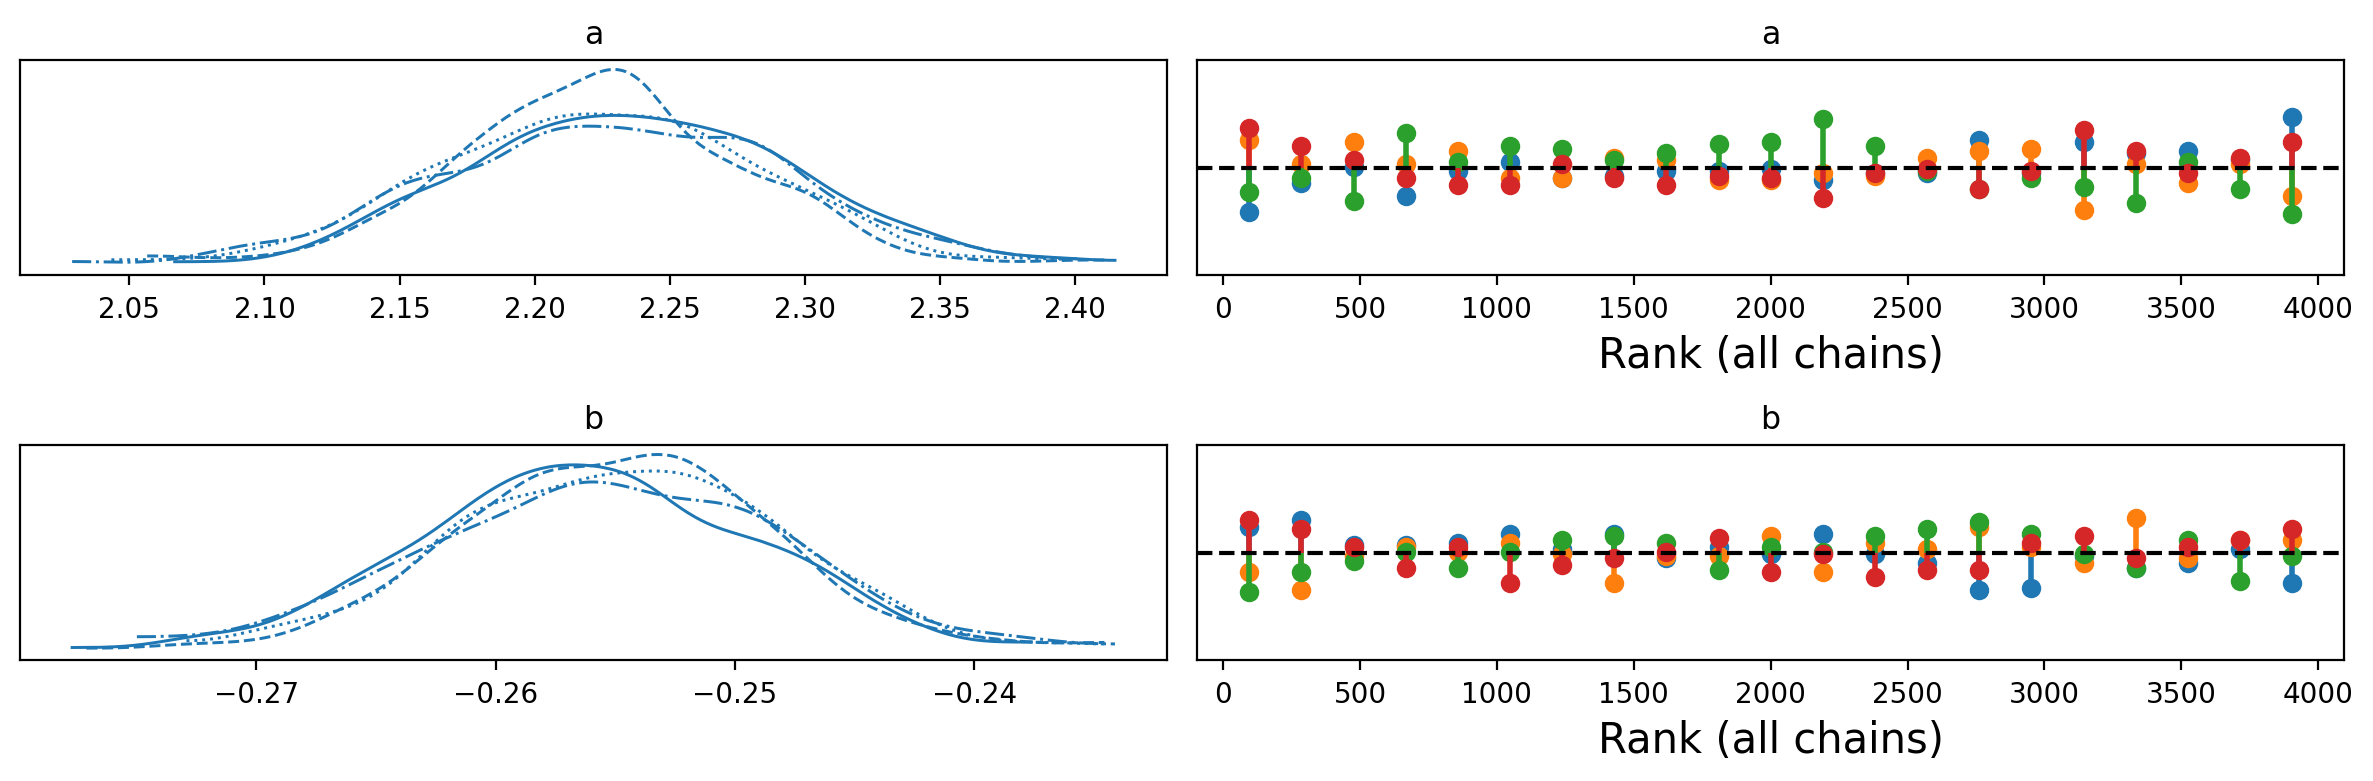

In [14]:
az.plot_trace(trace, kind="rank_vlines")
plt.tight_layout()


In [15]:
mcmc_samples = states.position


In [16]:
distance_ppc = np.linspace(0, 22.5, 200, dtype=np.float32)

# attempts_ppc = np.ones_like(distance_ppc) * 10000
# golf_logistic_ppc = gen_logistic_regression(distance_ppc, attempts_ppc)
# ppc = golf_logistic_ppc.sample(seed=rng, value=mcmc_samples).y
# ppc_prob = ppc / attempts_ppc

ppc_logit = mcmc_samples.a + mcmc_samples.b * distance_ppc[:, None, None]
ppc_prob = np.transpose(jax.nn.sigmoid(ppc_logit), [1, 2, 0])

lower, median, upper = np.percentile(ppc_prob, [2.5, 50, 97.5], axis=[0, 1])


Text(0.5, 1.0, 'Fitted logistic regression')

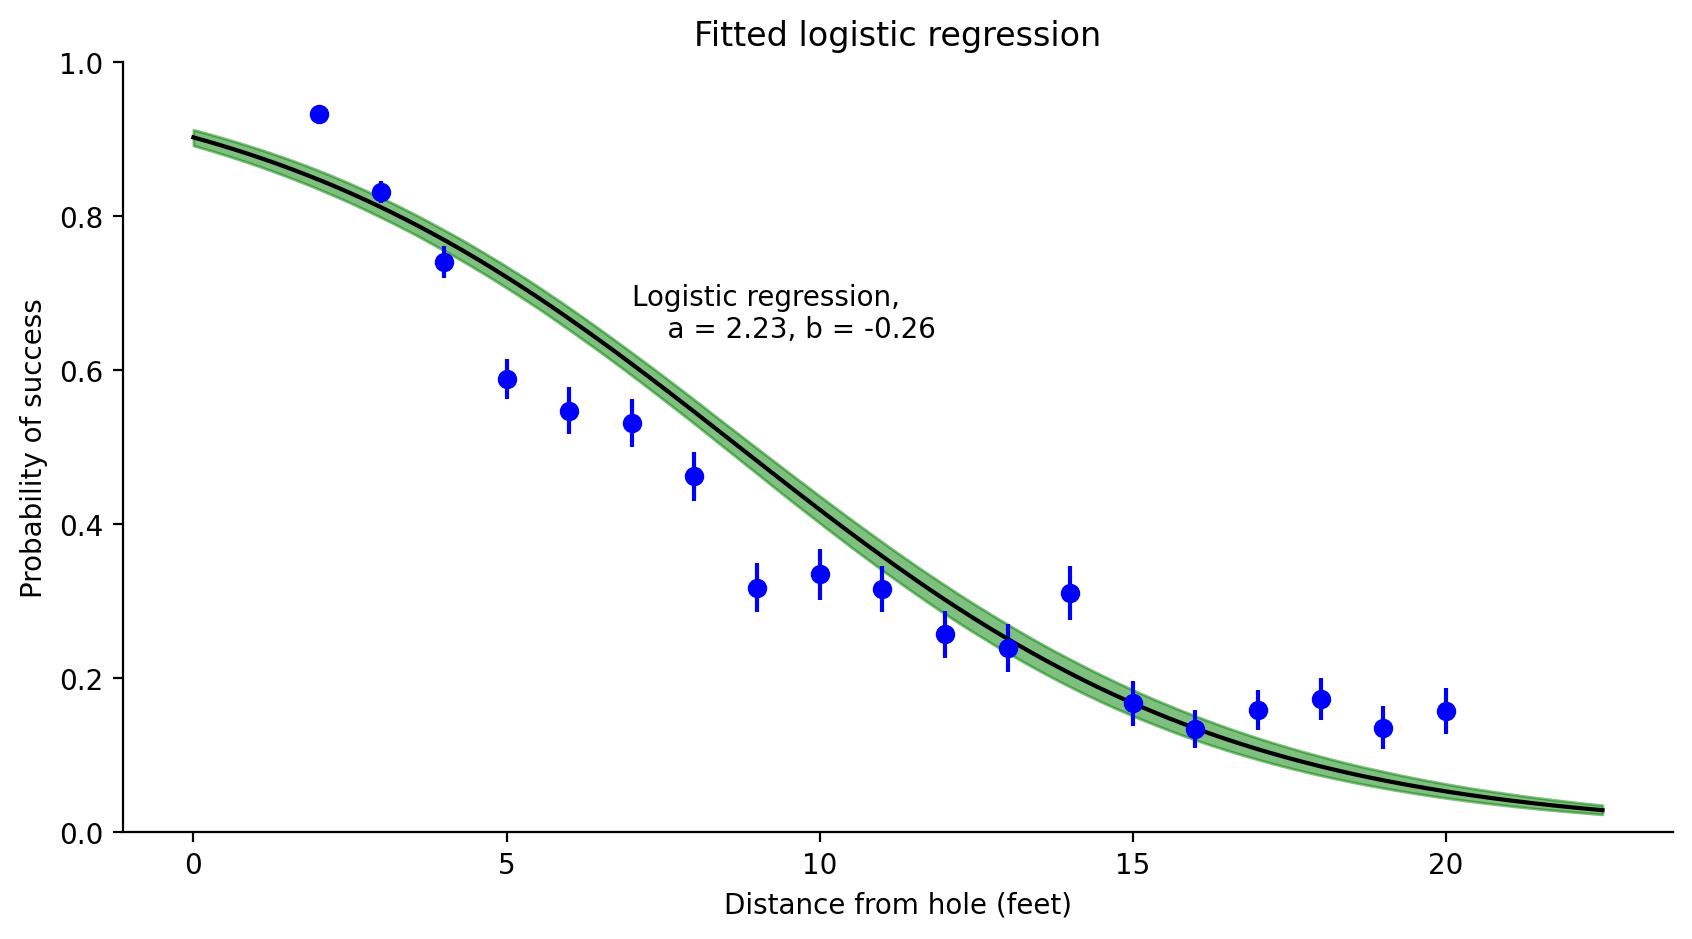

In [17]:
ax = plot_observed(golf_data)
ax.plot(distance_ppc, median, color="k")
ax.fill_between(distance_ppc, lower, upper, color="g", alpha=0.5)
ax.text(
    7,
    0.6,
    f"""Logistic regression,
    a = {np.mean(mcmc_samples.a):.2f}, b = {np.mean(mcmc_samples.b):.2f}
    """,
    fontsize=10,
)
ax.set_title("Fitted logistic regression")


### Same drill, but more functional programming

Isolate the prior and prediction subgraph of the model using `yield from`.
- Pro: return JointDistribution object that is identical to the original model
- Con: the function that generate the subgraph is not a pure function, because it has side effect (yielding the prior)

In [18]:
# modeling
def lr_prior_prediction(distance):
    a = yield tfd.Normal(0, 10, name="a")
    b = yield tfd.Normal(0, 10, name="b")
    logit_p = a + b * distance
    return jax.nn.sigmoid(logit_p)


def gen_golf_putting_model(distance, attempts, prediction_fn):
    @jdc
    def model():
        p = yield from prediction_fn(distance)
        yield tfd.Binomial(attempts, probs=p, name="y")

    return model


golf_logistic1 = gen_golf_putting_model(distance, attempts, lr_prior_prediction)
print(golf_logistic1.sample(seed=rng))

pinned_model1 = golf_logistic1.experimental_pin(y=successes)
_ = pinned_model1.sample_unpinned(seed=rng)


StructTuple(
  a=Array(4.0240216, dtype=float32),
  b=Array(3.756135, dtype=float32),
  y=Array([1443.,  694.,  455.,  353.,  272.,  256.,  240.,  217.,  200.,
            237.,  202.,  192.,  174.,  167.,  201.,  195.,  191.,  147.,
            152.], dtype=float32)
)


Isolate the prior, prediction (transformation that takes data and prior) in 2 separate functions.
- Pro: the transformations are pure functions, we can use it later for posterior predictive checks
- Con: prior is now in a structure, also `sample_unpinned` from a pinned model is currently broken in TFP

In [19]:
# modeling
from functools import partial


@partial(jdc, name="prior")
def prior():
    a = yield tfd.Normal(0, 10, name="a")
    b = yield tfd.Normal(0, 10, name="b")


def lr_prediction(distance, params):
    logit_p = params.a + distance * params.b
    return jax.nn.sigmoid(logit_p)


def gen_golf_putting_model(distance, attempts, prediction_fn, prior_jd):
    @jdc
    def model():
        params = yield prior_jd
        p = prediction_fn(distance, params)
        yield tfd.Binomial(attempts, probs=p, name="y")

    return model


golf_logistic2 = gen_golf_putting_model(distance, attempts, lr_prediction, prior)
print(golf_logistic2.sample(seed=rng))

pinned_model2 = golf_logistic2.experimental_pin(y=successes)
# _ = pinned_model2.sample_unpinned(seed=rng)  # <== error


StructTuple(
  prior=StructTuple(
      a=Array(-1.1071311, dtype=float32),
      b=Array(15.337342, dtype=float32)
    ),
  y=Array([1443.,  694.,  455.,  353.,  272.,  256.,  240.,  217.,  200.,
            237.,  202.,  192.,  174.,  167.,  201.,  195.,  191.,  147.,
            152.], dtype=float32)
)


In [20]:
# modeling
def lr_prediction(distance, *params):
    a, b = params
    logit_p = a + distance * b
    return jax.nn.sigmoid(logit_p)


def lr_prior_prediction(distance, prediction_fn):
    a = yield tfd.Normal(0, 10, name="a")
    b = yield tfd.Normal(0, 10, name="b")
    return prediction_fn(distance, a, b)


def gen_golf_putting_model(distance, attempts, prior_prediction_meta, prediction_fn):
    @jdc
    def model():
        p = yield from prior_prediction_meta(distance, prediction_fn)
        yield tfd.Binomial(attempts, probs=p, name="y")

    return model


golf_logistic3 = gen_golf_putting_model(
    distance, attempts, lr_prior_prediction, lr_prediction
)
print(golf_logistic3.sample(seed=rng))

pinned_model3 = golf_logistic3.experimental_pin(y=successes)
_ = pinned_model3.sample_unpinned(seed=rng)


StructTuple(
  a=Array(4.0240216, dtype=float32),
  b=Array(3.756135, dtype=float32),
  y=Array([1443.,  694.,  455.,  353.,  272.,  256.,  240.,  217.,  200.,
            237.,  202.,  192.,  174.,  167.,  201.,  195.,  191.,  147.,
            152.], dtype=float32)
)


In [21]:
# inference (reusing the same keys as above)
joint_logdensity = pinned_model3.unnormalized_log_prob

warmup = blackjax.window_adaptation(blackjax.nuts, joint_logdensity)

@jax.vmap
def call_warmup(seed, param):
    (initial_states, tuned_params), _ = warmup.run(seed, param, 1000)
    return initial_states, tuned_params


initial_states, tuned_params = call_warmup(
    keys, jax.tree_map(jnp.zeros_like, init_params)
)
lr_states, infos = inference_loop_multiple_chains(
    sample_key, initial_states, tuned_params, joint_logdensity, n_samples, n_chains
)

# criticism
trace = arviz_trace_from_states(lr_states, infos)
summ_df = az.summary(trace)
summ_df


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.230,0.060,2.128,2.348,0.002,0.001,1134.0,1199.0,1.0
b,-0.256,0.007,-0.268,-0.242,0.000,0.000,1196.0,1355.0,1.0


Text(0.5, 1.0, 'Fitted logistic regression')

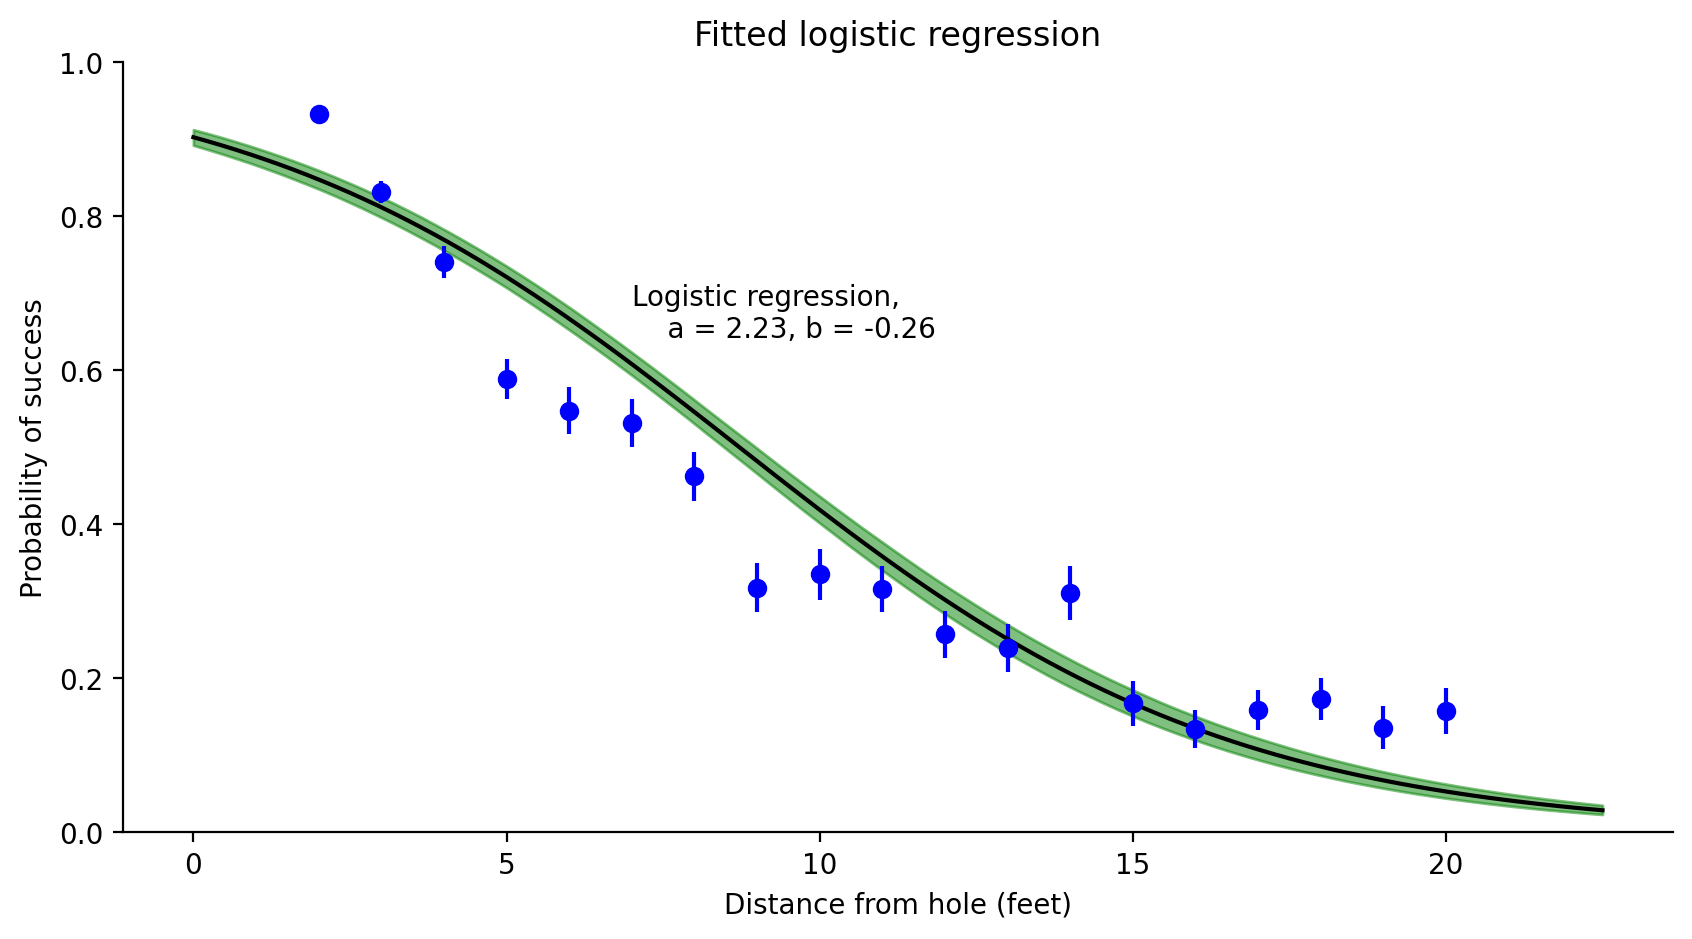

In [22]:
distance_ppc = np.linspace(0, 22.5, 100, dtype=np.float32)
lr_ppc_prob = lr_prediction(distance_ppc[:, None, None], *lr_states.position)
lower, median, upper = np.percentile(lr_ppc_prob, [2.5, 50, 97.5], axis=[1, 2])

ax = plot_observed(golf_data)
ax.plot(distance_ppc, median, color="k")
ax.fill_between(distance_ppc, lower, upper, color="g", alpha=0.5)
ax.text(
    7,
    0.6,
    f"""Logistic regression,
    a = {np.mean(mcmc_samples.a):.2f}, b = {np.mean(mcmc_samples.b):.2f}
    """,
    fontsize=10,
)
ax.set_title("Fitted logistic regression")


## Geometry-based model

In [23]:
r = (1.68 / 2) / 12  # ball radius
R = (4.25 / 2) / 12  # cup radius


/tmp/ipykernel_1185118/3585776161.py:8: RuntimeWarning: divide by zero encountered in divide
  threshold_angle = jnp.arcsin((R - r) / distance)


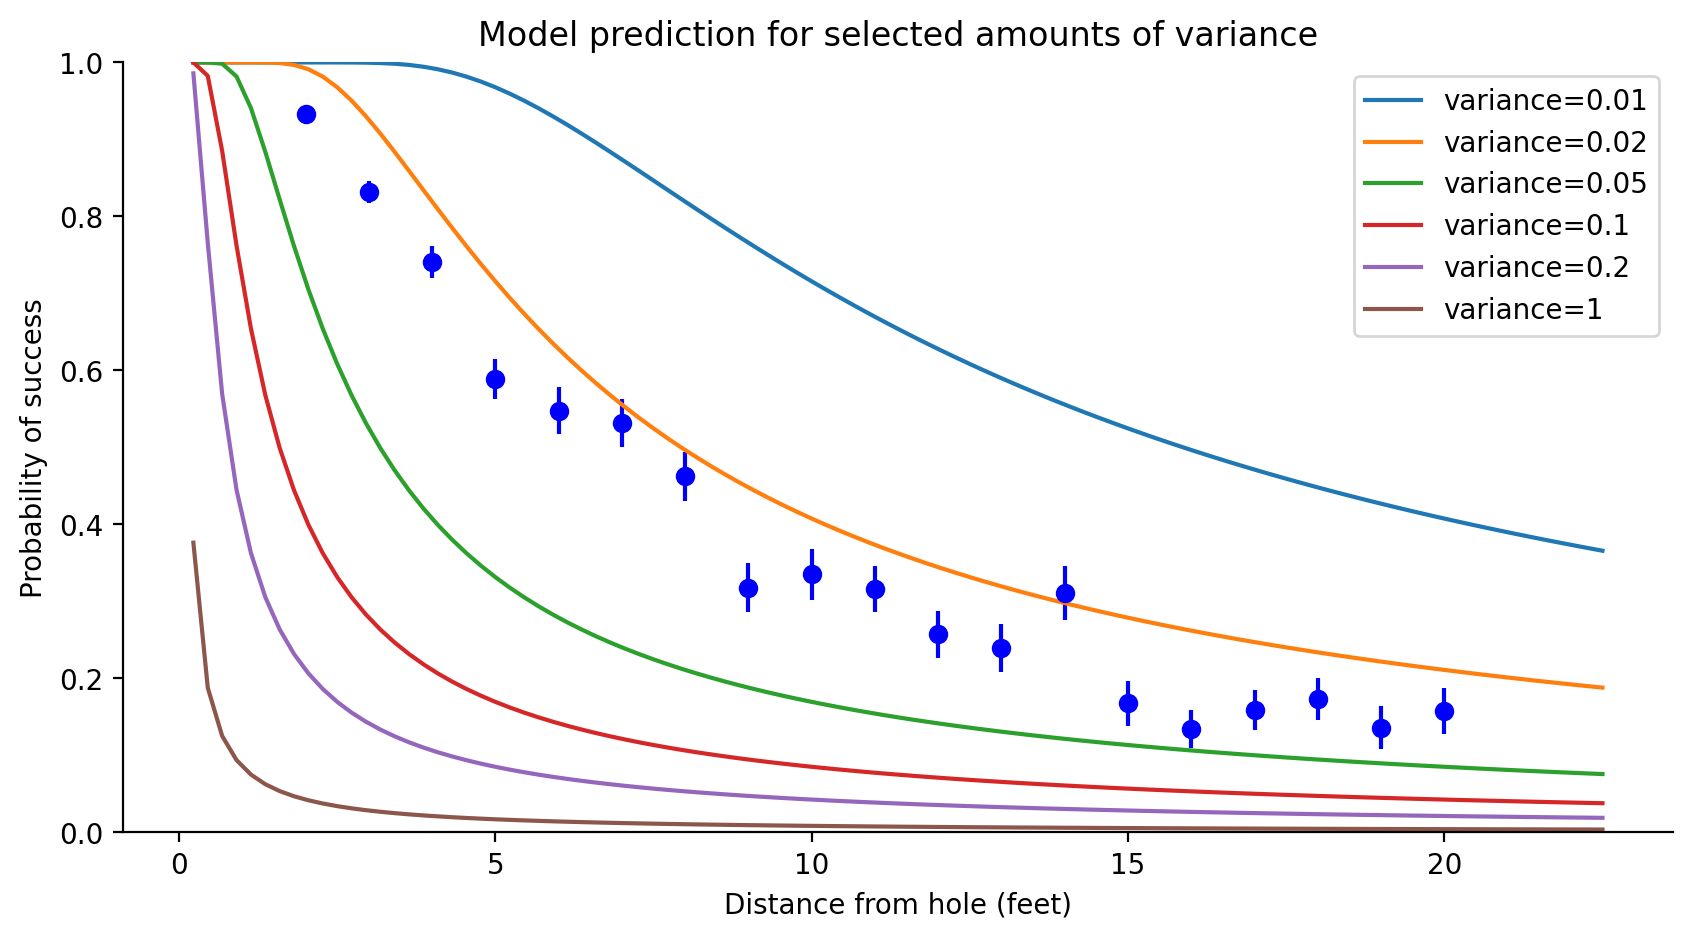

In [24]:
def _phi(x):
    """Standard normal cumulative distribution function."""
    return 0.5 + 0.5 * jsp.special.erf(x / jnp.sqrt(2.0))


def geometry_prediction(distance, *params):
    (sigma,) = params
    threshold_angle = jnp.arcsin((R - r) / distance)
    return 2 * _phi(threshold_angle / sigma) - 1


ax = plot_observed(golf_data)
for sigma in (0.01, 0.02, 0.05, 0.1, 0.2, 1):
    ax.plot(
        distance_ppc,
        geometry_prediction(distance_ppc, sigma),
        label=f"variance={sigma}",
    )
ax.set_title("Model prediction for selected amounts of variance")
ax.legend()


In [25]:
def geometry_prior_pred(distance, prediction_fn):
    sigma = yield tfd.HalfNormal(1, name="sigma")
    return prediction_fn(distance, sigma)


golf_geo = gen_golf_putting_model(
    distance, attempts, geometry_prior_pred, geometry_prediction
)
print(golf_geo.sample(seed=rng))

pinned_model = golf_geo.experimental_pin(y=successes)
_ = pinned_model.sample_unpinned(seed=rng)


StructTuple(
  sigma=Array(0.40240216, dtype=float32),
  y=Array([146.,  51.,  23.,  11.,  12.,   4.,   8.,   3.,   3.,   5.,   7.,
             5.,   4.,   2.,   0.,   1.,   1.,   4.,   2.], dtype=float32)
)


In [26]:
# # Get the default change of variable bijectors from the model
rng, init_key, sample_key = jax.random.split(rng, 3)
init_params = pinned_model.sample_unpinned(n_chains, seed=init_key)
bijectors = pinned_model.experimental_default_event_space_bijector()


def joint_logdensity(unbound_param):
    param = bijectors.forward(unbound_param)
    log_det_jacobian = bijectors.forward_log_det_jacobian(unbound_param)
    return pinned_model.unnormalized_log_prob(param) + log_det_jacobian


warmup = blackjax.window_adaptation(blackjax.nuts, joint_logdensity)


@jax.vmap
def call_warmup(seed, param):
    (initial_states, tuned_params), _ = warmup.run(seed, param, 1000)
    return initial_states, tuned_params


initial_states, tuned_params = call_warmup(keys, bijectors.inverse(init_params))
geo_states, infos = inference_loop_multiple_chains(
    sample_key, initial_states, tuned_params, joint_logdensity, n_samples, n_chains
)

# criticism
position = geo_states.position
geo_states = geo_states._replace(position=bijectors.forward(position))

trace = arviz_trace_from_states(geo_states, infos)
summ_df = az.summary(trace)
summ_df


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.027,0.0,0.026,0.027,0.0,0.0,1530.0,1463.0,1.0


In [27]:
geo_ppc_prob = geometry_prediction(distance_ppc[:, None, None], *geo_states.position)


/tmp/ipykernel_1185118/3585776161.py:8: RuntimeWarning: divide by zero encountered in divide
  threshold_angle = jnp.arcsin((R - r) / distance)


Text(0.5, 1.0, 'Two models fit to the golf putting data')

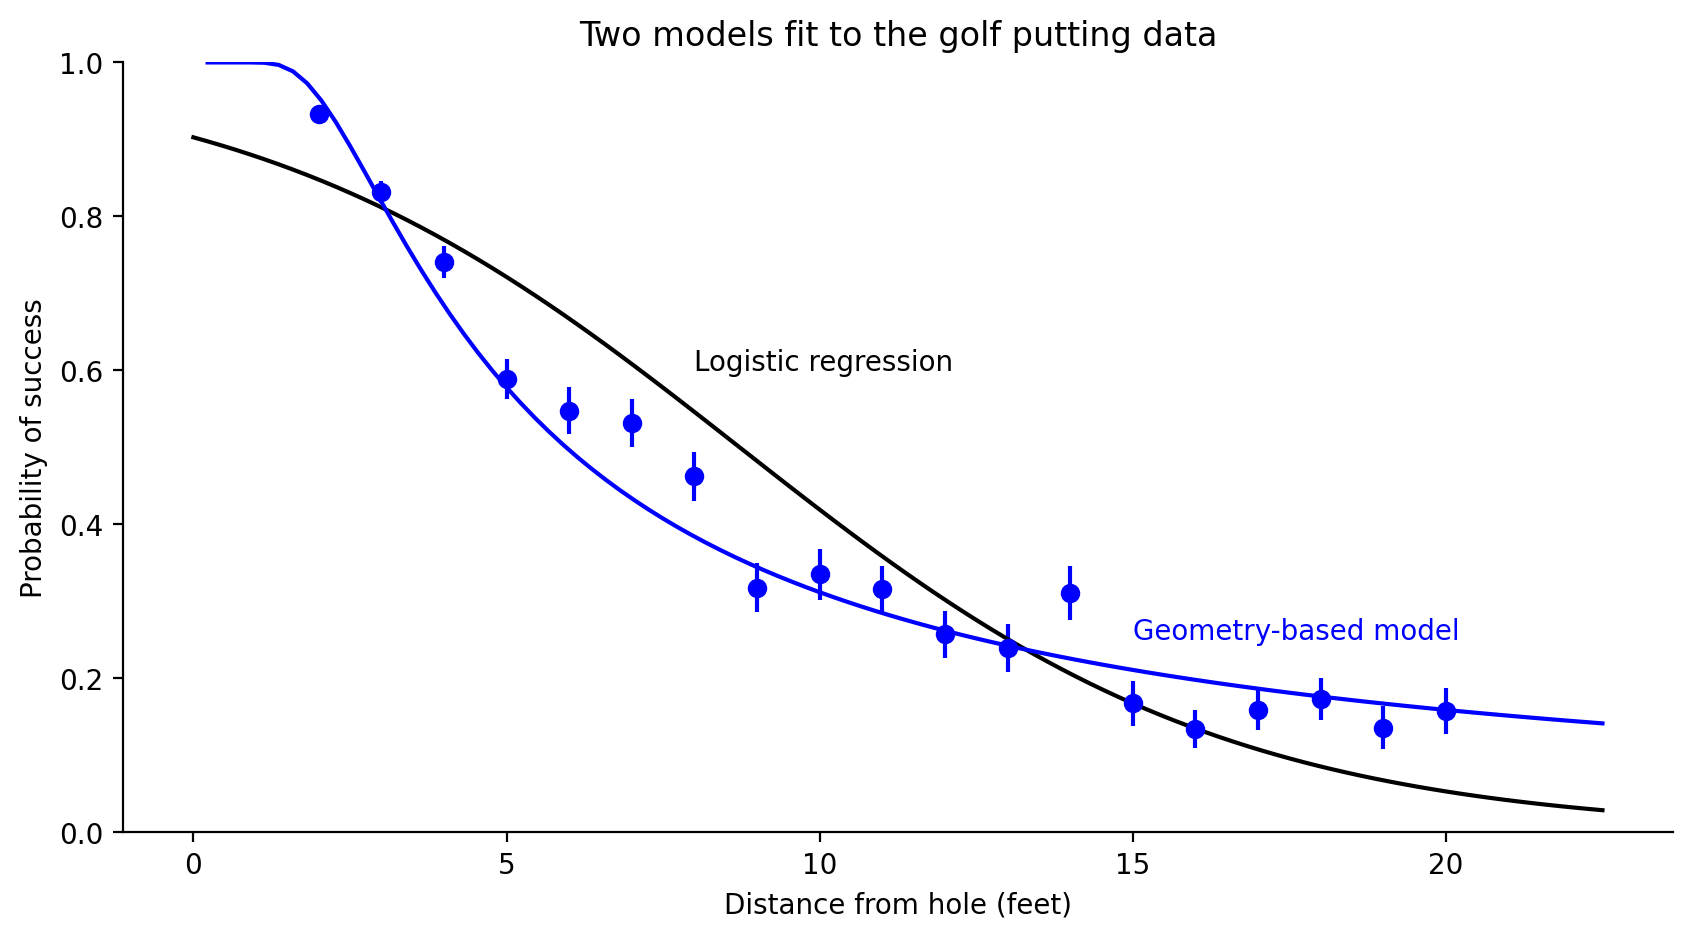

In [28]:
ax = plot_observed(golf_data)
ax.plot(distance_ppc, lr_ppc_prob.mean(axis=(1, 2)), color="k")
ax.text(8, 0.6, f"""Logistic regression""", fontsize=10)
ax.plot(distance_ppc, geo_ppc_prob.mean(axis=(1, 2)), color="b")
ax.text(15, 0.25, f"""Geometry-based model""", fontsize=10, color="b")
ax.set_title("Two models fit to the golf putting data")


### Testing the fitted model on new data


/tmp/ipykernel_1185118/3585776161.py:8: RuntimeWarning: divide by zero encountered in divide
  threshold_angle = jnp.arcsin((R - r) / distance)


Text(0.5, 1.0, 'Checking already-fit model to new data')

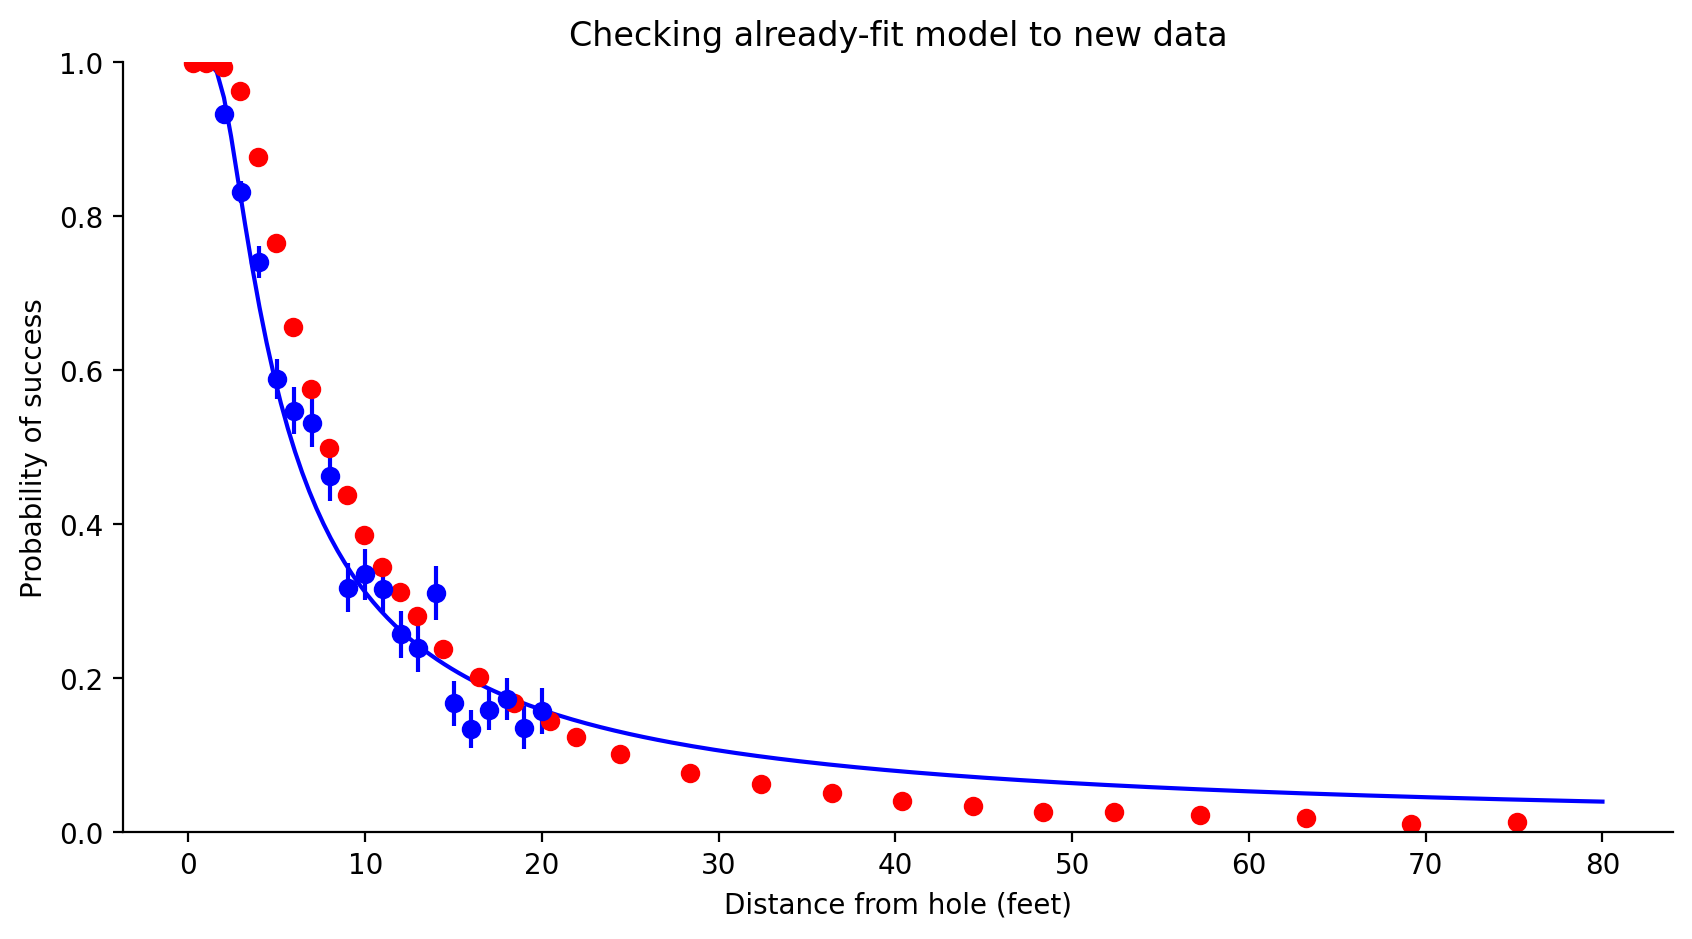

In [29]:
distance_ppc2 = np.linspace(0, 80, 200)
geo_ppc_prob2 = geometry_prediction(distance_ppc2[:, None, None], *geo_states.position)

ax = plot_observed(golf_data)
ax.plot(distance_ppc2, geo_ppc_prob2.mean(axis=(1, 2)), color="b")
plot_observed(golf_data_new, ax=ax, plot_err=False)
ax.set_title("Checking already-fit model to new data")


## A new model accounting for how hard the ball is hit

In [30]:
overshot = 1.0
distance_tolerance = 3.0


def geometry_prediction2(distance, *params):
    sigma_angle, sigma_distance = params
    threshold_angle = jnp.arcsin((R - r) / distance)
    p_angle = 2 * _phi(threshold_angle / sigma_angle) - 1
    p_distance = _phi(
        (distance_tolerance - overshot) / ((distance + overshot) * sigma_distance)
    ) - _phi(-overshot / ((distance + overshot) * sigma_distance))
    return p_angle * p_distance


def geometry_prior_pred2(distance, prediction_fn):
    sigma_angle = yield tfd.HalfNormal(1, name="sigma_angle")
    sigma_distance = yield tfd.HalfNormal(1, name="sigma_distance")
    return prediction_fn(distance, sigma_angle, sigma_distance)


distance_new = np.asarray(golf_data_new["distance"].values, dtype=np.float32)
attempts_new = np.asarray(golf_data_new["attempts"].values, dtype=np.float32)
successes_new = np.asarray(golf_data_new["successes"].values, dtype=np.float32)
golf_geo = gen_golf_putting_model(
    distance_new, attempts_new, geometry_prior_pred2, geometry_prediction2
)
print(golf_geo.sample(seed=rng))

pinned_model = golf_geo.experimental_pin(y=successes_new)
_ = pinned_model.sample_unpinned(seed=rng)


StructTuple(
  sigma_angle=Array(0.521258, dtype=float32),
  sigma_distance=Array(0.30700457, dtype=float32),
  y=Array([2.4460e+04, 2.9376e+04, 1.2364e+04, 4.7600e+03, 2.0850e+03,
           9.9000e+02, 5.8400e+02, 3.9000e+02, 2.5700e+02, 1.9500e+02,
           1.6900e+02, 1.0100e+02, 1.0800e+02, 7.1000e+01, 1.4000e+02,
           8.3000e+01, 5.7000e+01, 3.4000e+01, 1.9000e+01, 5.1000e+01,
           2.6000e+01, 2.3000e+01, 1.5000e+01, 8.0000e+00, 3.0000e+00,
           2.0000e+00, 3.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00], dtype=float32)
)


In [31]:
# # Get the default change of variable bijectors from the model
rng, init_key, sample_key = jax.random.split(rng, 3)
init_params = pinned_model.sample_unpinned(n_chains, seed=init_key)
bijectors = pinned_model.experimental_default_event_space_bijector()


def joint_logdensity(unbound_param):
    param = bijectors.forward(unbound_param)
    log_det_jacobian = bijectors.forward_log_det_jacobian(unbound_param)
    return pinned_model.unnormalized_log_prob(param) + log_det_jacobian


warmup = blackjax.window_adaptation(blackjax.nuts, joint_logdensity)


@jax.vmap
def call_warmup(seed, param):
    (initial_states, tuned_params), _ = warmup.run(seed, param, 1000)
    return initial_states, tuned_params


initial_states, tuned_params = call_warmup(keys, bijectors.inverse(init_params))
geo_states, infos = inference_loop_multiple_chains(
    sample_key, initial_states, tuned_params, joint_logdensity, n_samples, n_chains
)

# criticism
position = geo_states.position
geo_states = geo_states._replace(position=bijectors.forward(position))

trace = arviz_trace_from_states(geo_states, infos)
summ_df = az.summary(trace)
summ_df


/home/junpenglao/miniconda3/envs/bayescomp23/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/junpenglao/miniconda3/envs/bayescomp23/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_angle,0.564,0.896,0.016,2.115,0.446,0.342,4.0,4.0,inf
sigma_distance,0.125,0.062,0.042,0.209,0.031,0.024,4.0,4.0,inf


In [32]:
geo_ppc_prob = geometry_prediction2(distance_ppc2[:, None, None], *geo_states.position)


/tmp/ipykernel_1185118/2754229921.py:7: RuntimeWarning: divide by zero encountered in divide
  threshold_angle = jnp.arcsin((R - r) / distance)


Text(0.5, 1.0, 'Checking model fit')

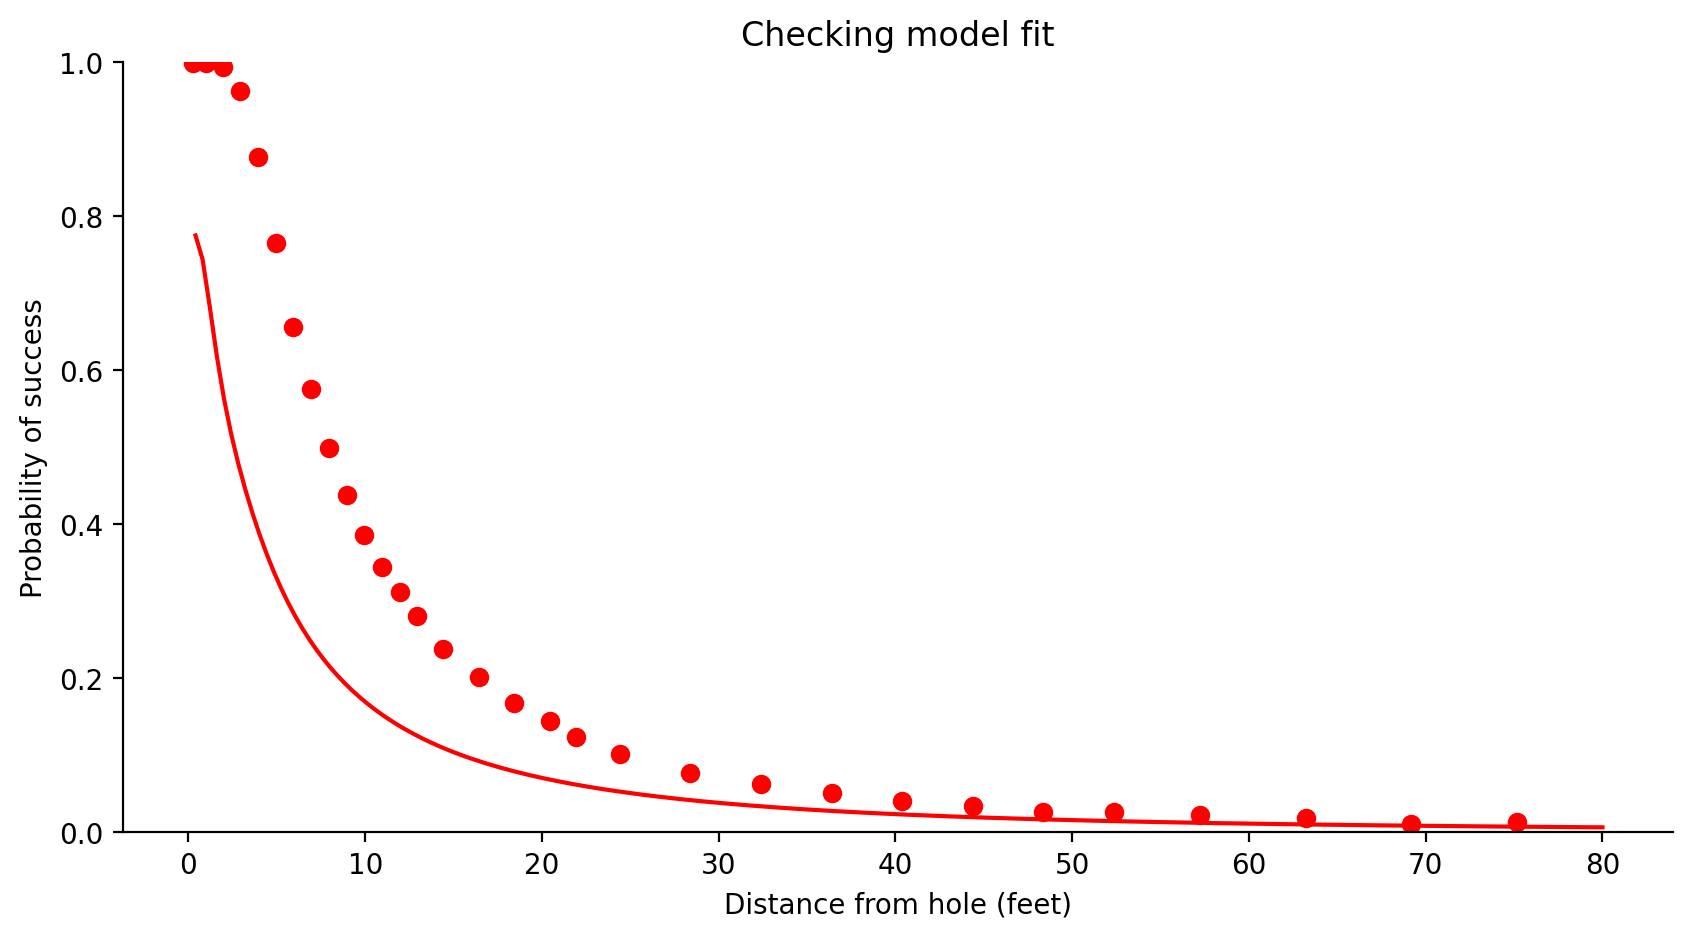

In [33]:
ax = plot_observed(golf_data_new, plot_err=False)
ax.plot(distance_ppc2, geo_ppc_prob.mean(axis=(1, 2)), color="r")
ax.set_title("Checking model fit")


In [34]:
def gen_golf_putting_model2(
    distance, attempts, prior_prediction_meta, prediction_fn, likelihood_dist
):
    @jdc
    def model():
        kwargs = yield from prior_prediction_meta(distance, attempts, prediction_fn)
        yield likelihood_dist(name="y", **kwargs)

    return model


def geometry_prediction3(distance, attempts, *params):
    *params0, dispersion = params
    p = geometry_prediction2(distance, *params0)
    scale = jnp.sqrt(((p * (1 - p)) / attempts) + dispersion**2)
    return {"loc": p, "scale": scale}


def geometry_prior_pred3(distance, attempts, prediction_fn):
    sigma_angle = yield tfd.HalfNormal(1, name="sigma_angle")
    sigma_distance = yield tfd.HalfNormal(1, name="sigma_distance")
    dispersion = yield tfd.HalfNormal(1, name="dispersion")
    return prediction_fn(distance, attempts, sigma_angle, sigma_distance, dispersion)


golf_geo = gen_golf_putting_model2(
    distance_new, attempts_new, geometry_prior_pred3, geometry_prediction3, tfd.Normal
)
print(golf_geo.sample(seed=rng))

pinned_model = golf_geo.experimental_pin(y=successes_new / attempts_new)
_ = pinned_model.sample_unpinned(seed=rng)


StructTuple(
  sigma_angle=Array(0.29095042, dtype=float32),
  sigma_distance=Array(0.7306348, dtype=float32),
  dispersion=Array(2.1888874, dtype=float32),
  y=Array([-0.49747902,  0.66841775,  1.9170233 , -0.10025775, -3.7749016 ,
            1.1601007 , -2.0444505 , -0.81734335, -0.08507231,  2.291445  ,
           -3.0398362 , -0.29339567,  2.3251307 ,  0.8725762 , -1.0738362 ,
            1.2589428 ,  2.2426345 , -1.2395985 , -0.9838934 , -2.4196424 ,
            1.0382451 , -0.55113596,  2.1623034 , -0.73337245, -2.208066  ,
           -0.6465245 ,  2.273523  ,  0.7389121 ,  0.07922122,  0.5718728 ,
            0.28718522], dtype=float32)
)


In [35]:
# # Get the default change of variable bijectors from the model
rng, init_key, sample_key = jax.random.split(rng, 3)
init_params = pinned_model.sample_unpinned(n_chains, seed=init_key)
bijectors = pinned_model.experimental_default_event_space_bijector()


def joint_logdensity(unbound_param):
    param = bijectors.forward(unbound_param)
    log_det_jacobian = bijectors.forward_log_det_jacobian(unbound_param)
    return pinned_model.unnormalized_log_prob(param) + log_det_jacobian


warmup = blackjax.window_adaptation(blackjax.nuts, joint_logdensity)


@jax.vmap
def call_warmup(seed, param):
    (initial_states, tuned_params), _ = warmup.run(seed, param, 1000)
    return initial_states, tuned_params


initial_states, tuned_params = call_warmup(keys, bijectors.inverse(init_params))
geo_states, infos = inference_loop_multiple_chains(
    sample_key, initial_states, tuned_params, joint_logdensity, n_samples, n_chains
)

# criticism
position = geo_states.position
geo_states = geo_states._replace(position=bijectors.forward(position))

trace = arviz_trace_from_states(geo_states, infos)
summ_df = az.summary(trace)
summ_df


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_angle,0.018,0.000,0.018,0.018,0.0,0.0,1471.0,1636.0,1.0
sigma_distance,0.080,0.001,0.078,0.083,0.0,0.0,1436.0,1450.0,1.0
dispersion,0.003,0.001,0.002,0.004,0.0,0.0,2038.0,2023.0,1.0


In [36]:
*params0_posterior, dispersion_posterior = geo_states.position
geo_ppc_prob = geometry_prediction2(distance_ppc2[:, None, None], *params0_posterior)


/tmp/ipykernel_1185118/2754229921.py:7: RuntimeWarning: divide by zero encountered in divide
  threshold_angle = jnp.arcsin((R - r) / distance)


Text(0.5, 1.0, 'Checking model fit')

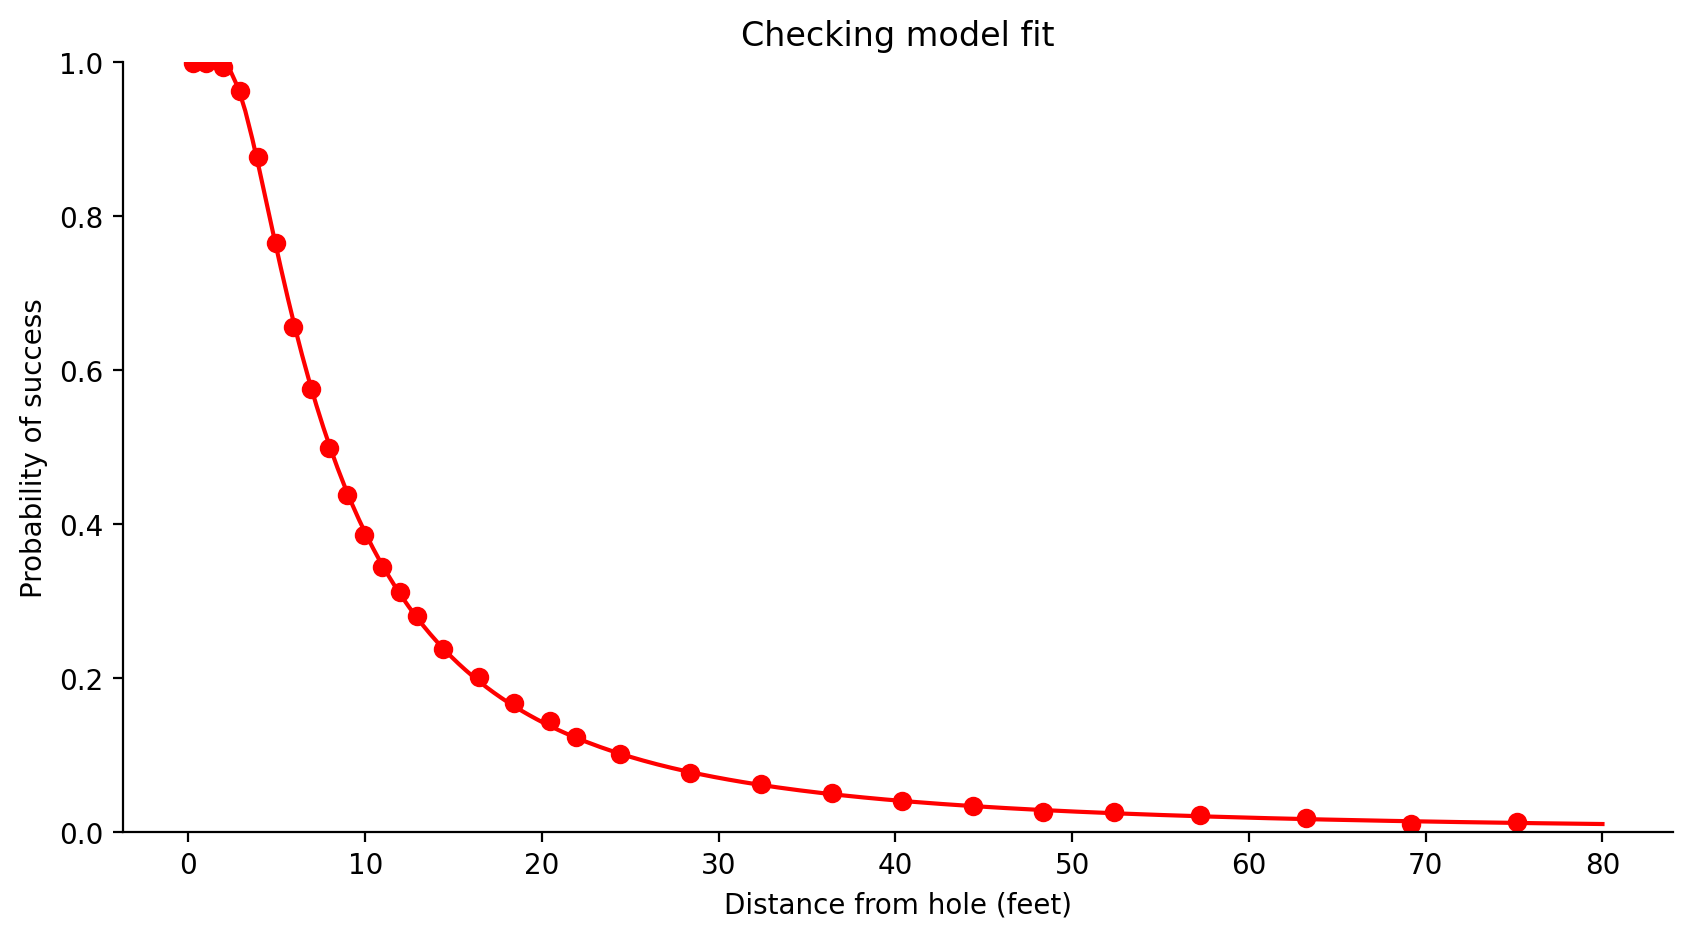

In [37]:
ax = plot_observed(golf_data_new, plot_err=False)
ax.plot(distance_ppc2, geo_ppc_prob.mean(axis=(1, 2)), color="r")
ax.set_title("Checking model fit")


[Text(0.5, 0, 'Distance from hole (feet)'),
 Text(0, 0.5, 'y/n - fitted E(y/n)'),
 Text(0.5, 1.0, 'Residuals from fitted model')]

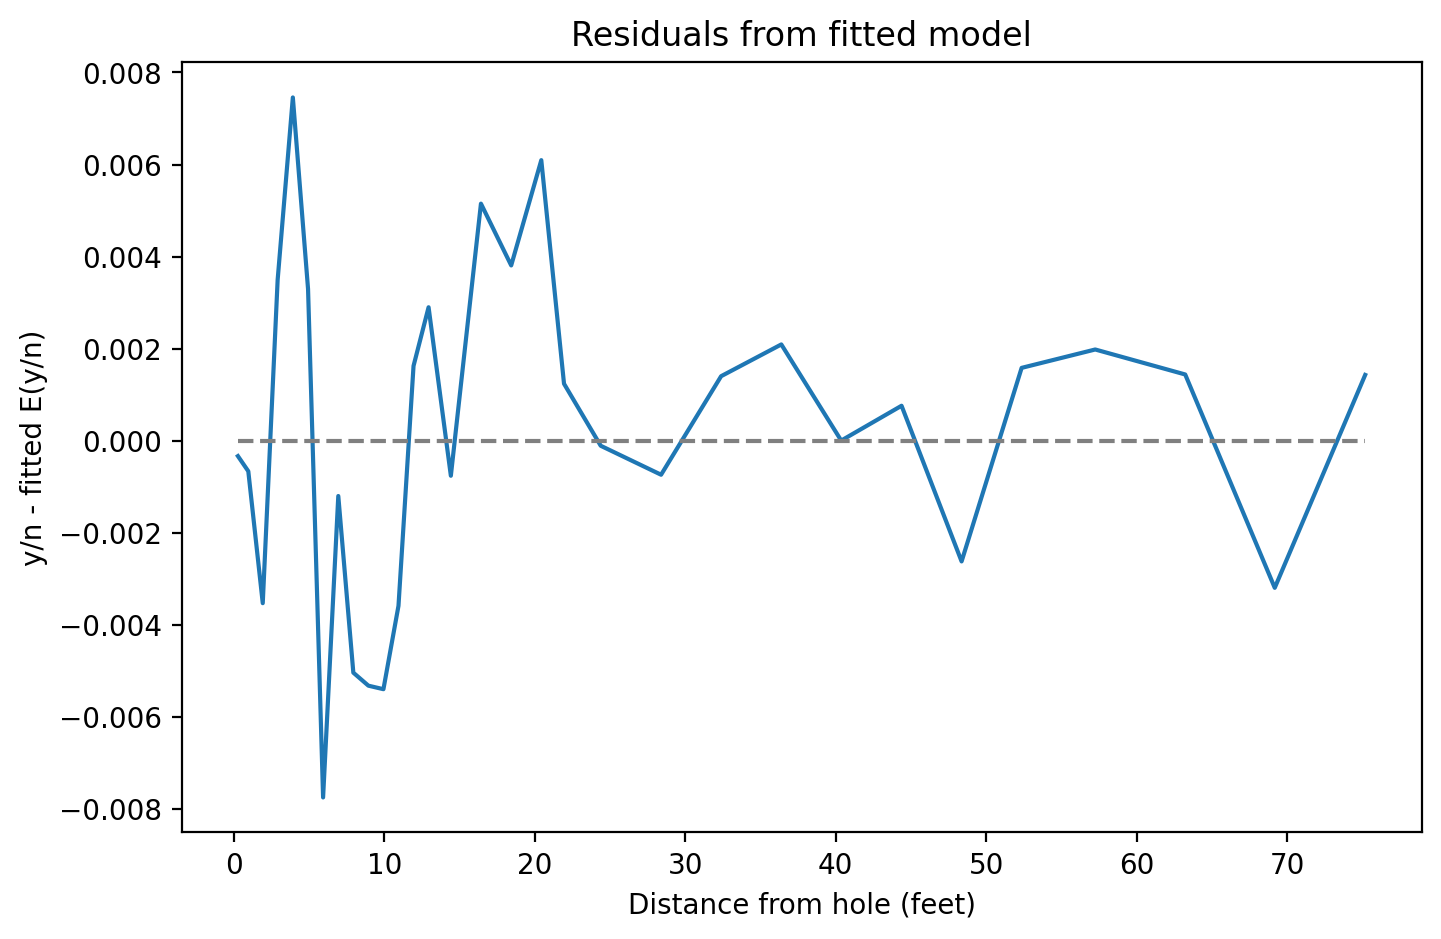

In [38]:
geo_ppc_prob = geometry_prediction2(distance_new[:, None, None], *params0_posterior)
residuals = successes_new / attempts_new - geo_ppc_prob.mean(axis=(1, 2))

_, ax = plt.subplots(figsize=(8, 5))
ax.plot(distance_new, residuals)
ax.hlines(0, distance_new.min(), distance_new.max(), ls="--", color="gray")
ax.set(
    xlabel="Distance from hole (feet)",
    ylabel="y/n - fitted E(y/n)",
    title="Residuals from fitted model",
)
